In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv1d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm1d(num_features=out_channels))
    return result

class RepConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=1, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepConvBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        if deploy:
            self.rbr_reparam = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm1d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.rbr_reparam(inputs)

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out

    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm1d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def switch_to_deploy(self):
        if hasattr(self, 'rbr_reparam'):
            return
        kernel, bias = self.get_equivalent_kernel_bias()
        self.rbr_reparam = nn.Conv1d(in_channels=self.rbr_dense.conv.in_channels, out_channels=self.rbr_dense.conv.out_channels,
                                     kernel_size=self.rbr_dense.conv.kernel_size, stride=self.rbr_dense.conv.stride,
                                     padding=self.rbr_dense.conv.padding, dilation=self.rbr_dense.conv.dilation, groups=self.rbr_dense.conv.groups, bias=True)
        self.rbr_reparam.weight.data = kernel
        self.rbr_reparam.bias.data = bias
        self.__delattr__('rbr_dense')
        self.__delattr__('rbr_1x1')
        if hasattr(self, 'rbr_identity'):
            self.__delattr__('rbr_identity')
        if hasattr(self, 'id_tensor'):
            self.__delattr__('id_tensor')
        self.deploy = True

class RepHAR(nn.Module):
    def __init__(self, nc_input, n_classes):
        super(RepHAR, self).__init__()

        self.stage1 = RepConvBlock(nc_input, 64, 3)
        self.stage2 = RepConvBlock(64, 128, 3)
        self.stage3 = RepConvBlock(128, 256, 3)
        
        self.fc = nn.Linear(256, n_classes)
    
    def forward(self, x):

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)

        x = F.adaptive_avg_pool1d(x,1)
        x = x.view(x.size(0), -1)

        logits = self.fc(x)

        return logits


RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  None


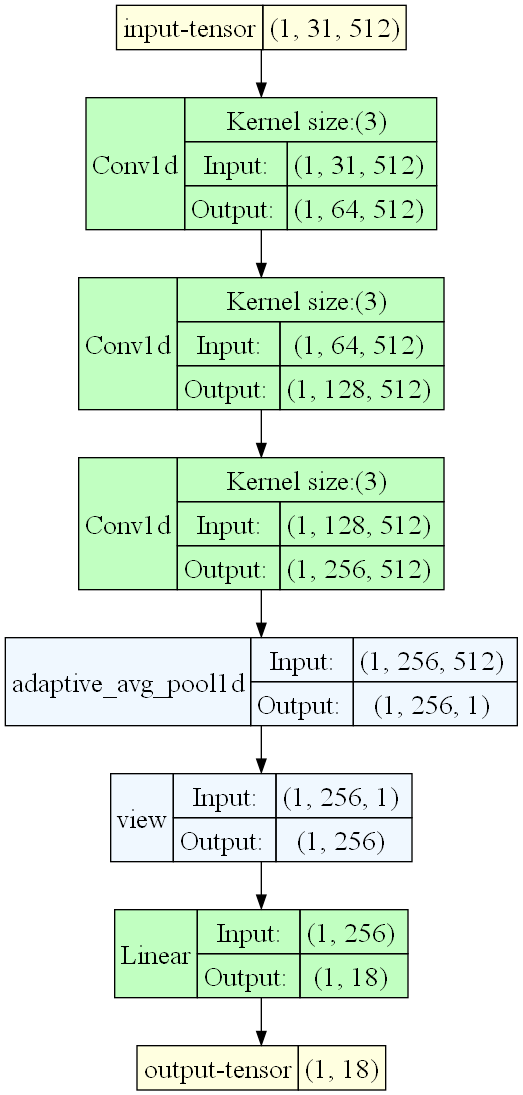

In [2]:
from utils import data_info
# import os
# os.environ["PATH"]+=os.pathsep+'C:\\Program Files\\Graphviz\\bin'
import graphviz
graphviz.set_jupyter_format('png')

#dataset = "UCI_HAR"
#dataset = "UniMiB-SHAR"
#dataset = "OPPORTUNITY"
dataset = "PAMAP2"
#dataset = "DSADS"
#dataset = "KU-HAR"
#dataset = "REALDISP"


input_nc, segment_size, class_num = data_info(dataset)

model = RepHAR(input_nc, class_num)
for module in model.modules():
    if hasattr(module, 'switch_to_deploy'):
        module.switch_to_deploy()

from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, input_nc, segment_size), save_graph=True, filename="RepHAR", expand_nested=False)
model_graph.visual_graph